## Importation des données

In [1]:
import pandas
import numpy as np

In [2]:
raw = pandas.read_excel('filtered_data.xlsx')

In [3]:
raw.columns

Index(['Last Name', 'First Name', 'Position', 'GP', 'G', 'A', 'A1', 'PTS',
       '+/-', 'IPP%', 'TOI/GP', 'iCF', 'iFF', 'iSF', 'iSCF', 'iHDCF', 'iRush',
       'iReb', 'Pass', 'ZS%', 'iGVA', 'iTKA', 'iBLK', 'S.Bkhd', 'S.Dflct',
       'S.Slap', 'S.Snap', 'S.Tip', 'S.Wrap', 'S.Wrst', 'CF', 'CA', 'FF', 'FA',
       'SF', 'SA', 'Ht', 'Wt', 'Age', 'PIM'],
      dtype='object')

In [4]:
player_names = raw['First Name'].values + ' ' + raw['Last Name'].values
raw = raw.drop(columns=['First Name', 'Last Name'])

In [5]:
targets_goals = raw['G'].values.reshape(-1,1).astype(dtype = 'float32')
targets_assists = raw['A'].values.reshape(-1,1).astype(dtype = 'float32')
targets_primary_assists = raw['A1'].values.reshape(-1,1).astype(dtype = 'float32')
targets_points = raw['PTS'].values.reshape(-1,1).astype(dtype = 'float32')
targets_plusminus = raw['+/-'].values.reshape(-1,1).astype(dtype = 'float32')
raw = raw.drop(columns = ['G', 'A', 'A1','PTS', '+/-'])

In [6]:
for i,position in enumerate(raw['Position']):
    if position in ['C/RW', 'LW/C', 'LW/RW', 'RW/C', 'LW', 'RW']:
        raw['Position'][i] = 'W'
one_hot_position = pandas.get_dummies(raw['Position'])
raw = raw.drop(columns = ['Position'])

D:\Programmes\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
def shuffle_data(*sets):
    rng_state = np.random.get_state()
    for set in sets:
        np.random.set_state(rng_state)
        np.random.shuffle(set)

In [8]:
data = np.concatenate((one_hot_position, raw.values), axis=1).astype(dtype = 'float32')
np.random.seed(6)
shuffle_data(player_names, targets_goals, targets_assists, targets_primary_assists, targets_plusminus, targets_points, data)

In [9]:
train_size = int(data.shape[0] * 0.70)
valid_size = int(data.shape[0] * 0.10)
split = np.array([train_size+valid_size])

In [10]:
#Separate training and test sets
training_player_names, test_player_names = np.split(player_names, split)
training_targets_goals, test_targets_goals = np.split(targets_goals, split)
training_targets_assists, test_targets_assists = np.split(targets_assists, split)
training_targets_primary_assists, test_targets_primary_assists = np.split(targets_primary_assists, split)
training_targets_plusminus, test_targets_plusminus = np.split(targets_plusminus, split)
training_targets_points, test_targets_points = np.split(targets_points, split)
training_data, test_data = np.split(data, split)

## MLP

In [11]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim
import time
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR

In [112]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.fc1 = nn.Linear(35, 200)
        self.fc2 = nn.Linear(200,200)
        self.fc3 = nn.Linear(200, 1)
        self.bn1 = nn.BatchNorm1d(num_features=35)
        self.drop = nn.Dropout(p=0.15)
    
    def forward(self, x):
        x = self.fc1(self.drop(self.bn1(x)))
        x = self.fc2(self.drop(torch.sigmoid(x)))
        x = self.fc3(self.drop(torch.sigmoid(x)))
        return F.relu(x)

In [13]:
class hockey_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, data, labels, transforms=None):
        self.data = data
        self.labels = labels
        self.transforms = transforms
        
    def __getitem__(self, index):
        d = self.data[index]
        if self.transforms is not None:
            d = self.transforms(d)
        return (d, self.labels[index])
    
    def __len__(self):
        return self.labels.shape[0]

In [106]:
def train(train_data, train_labels, nepochs):
    
    trainset = hockey_dataset(train_data[:train_size], train_labels[:train_size])
    validset = hockey_dataset(train_data[train_size:], train_labels[train_size:])

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle = True)
    validloader = torch.utils.data.DataLoader(validset, batch_size=len(validset), shuffle = False)
    
    network = Network().to(device)
    criterion = nn.MSELoss()
    lr = 0.01
    optimizer = torch.optim.SGD(network.parameters(), lr = lr,
                            weight_decay=0.01, momentum = 0)
    
    loss_train, loss_valid = [],[]
    
    for epoch in range(nepochs):
        if (epoch > 0) and (epoch%100 == 0):
            lr = lr*0.85
            optimizer = torch.optim.SGD(network.parameters(), lr = lr,
                            weight_decay=0.01, momentum = 0)
        current_loss_train, current_loss_valid = 0,0
        network.train()
        for data in trainloader:
            inputs, label = data
            optimizer.zero_grad()
            output = network(inputs.to(device))
            loss = criterion(output, label.to(device))
            loss.backward()
            optimizer.step()
            current_loss_train += loss.item()/train_size
            loss_train.append(current_loss_train)
        
        with torch.no_grad():
            network.eval()
            for data in validloader:
                inputs, label = data

                output = network(inputs.to(device))
                loss = criterion(output, label.to(device))
                current_loss_valid += loss.item()/valid_size
                loss_valid.append(current_loss_valid)
        if epoch%100 == 0:
            print('Epoch: {}'.format(epoch))
            print('Train loss: {0:.4f}'.format(loss_train[-1]))
            print('Valid loss: {0:.4f}'.format(loss_valid[-1]))
    print('Mean loss of last 50 iterations(test): ',np.array(loss_train[-50:]).mean())
    print('Mean loss of last 50 iterations(valid): ',np.array(loss_valid[-50:]).mean())   
    return loss_train, loss_valid, network

In [107]:
def predict(network, test_data, test_labels):
    testset = hockey_dataset(test_data, test_labels)
    testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle = False)
    
    network.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, label = data
            predictions = network(inputs.to(device))
    return predictions.cpu().numpy()

In [108]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'GeForce GTX 1050'

Epoch: 0
Train loss: 0.2563
Valid loss: 1.3685
Epoch: 100
Train loss: 0.0252
Valid loss: 0.1691
Epoch: 200
Train loss: 0.0214
Valid loss: 0.1591
Epoch: 300
Train loss: 0.0219
Valid loss: 0.1538
Epoch: 400
Train loss: 0.0213
Valid loss: 0.1489
Epoch: 500
Train loss: 0.0182
Valid loss: 0.1453
Epoch: 600
Train loss: 0.0202
Valid loss: 0.1421
Epoch: 700
Train loss: 0.0187
Valid loss: 0.1398
Epoch: 800
Train loss: 0.0205
Valid loss: 0.1376
Epoch: 900
Train loss: 0.0183
Valid loss: 0.1364
Epoch: 1000
Train loss: 0.0174
Valid loss: 0.1356
Mean loss of last 50 iterations(test):  0.018697538942242128
Mean loss of last 50 iterations(valid):  0.1357493574163887
Temps d'entrainement : 13.738664865493774


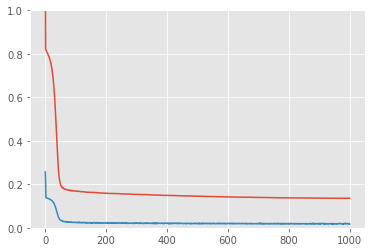

Epoch: 0
Train loss: 0.6581
Valid loss: 4.4953
Epoch: 100
Train loss: 0.0441
Valid loss: 0.3243
Epoch: 200
Train loss: 0.0350
Valid loss: 0.2902
Epoch: 300
Train loss: 0.0388
Valid loss: 0.2808
Epoch: 400
Train loss: 0.0358
Valid loss: 0.2795
Epoch: 500
Train loss: 0.0358
Valid loss: 0.2772
Epoch: 600
Train loss: 0.0310
Valid loss: 0.2745
Epoch: 700
Train loss: 0.0329
Valid loss: 0.2707
Epoch: 800
Train loss: 0.0316
Valid loss: 0.2692
Epoch: 900
Train loss: 0.0311
Valid loss: 0.2687
Epoch: 1000
Train loss: 0.0353
Valid loss: 0.2683
Mean loss of last 50 iterations(test):  0.033101622335026774
Mean loss of last 50 iterations(valid):  0.26797626623946624
Temps d'entrainement : 14.72861099243164


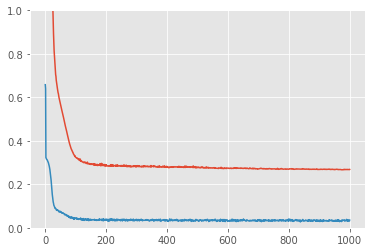

Epoch: 0
Train loss: 0.2153
Valid loss: 1.4116
Epoch: 100
Train loss: 0.0192
Valid loss: 0.1273
Epoch: 200
Train loss: 0.0160
Valid loss: 0.0930
Epoch: 300
Train loss: 0.0171
Valid loss: 0.0883
Epoch: 400
Train loss: 0.0165
Valid loss: 0.0866
Epoch: 500
Train loss: 0.0136
Valid loss: 0.0847
Epoch: 600
Train loss: 0.0144
Valid loss: 0.0832
Epoch: 700
Train loss: 0.0160
Valid loss: 0.0813
Epoch: 800
Train loss: 0.0158
Valid loss: 0.0809
Epoch: 900
Train loss: 0.0152
Valid loss: 0.0805
Epoch: 1000
Train loss: 0.0131
Valid loss: 0.0795
Mean loss of last 50 iterations(test):  0.01435352538217511
Mean loss of last 50 iterations(valid):  0.07964924512284524
Temps d'entrainement : 13.32621693611145


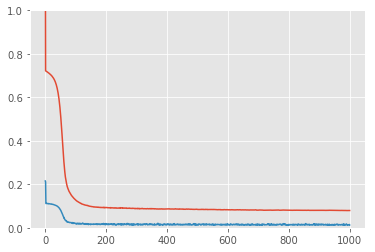

Epoch: 0
Train loss: 1.6245
Valid loss: 7.8635
Epoch: 100
Train loss: 0.1113
Valid loss: 0.6805
Epoch: 200
Train loss: 0.0950
Valid loss: 0.5712
Epoch: 300
Train loss: 0.0583
Valid loss: 0.5055
Epoch: 400
Train loss: 0.0562
Valid loss: 0.4759
Epoch: 500
Train loss: 0.0569
Valid loss: 0.4701
Epoch: 600
Train loss: 0.0603
Valid loss: 0.4599
Epoch: 700
Train loss: 0.0473
Valid loss: 0.4575
Epoch: 800
Train loss: 0.0542
Valid loss: 0.4503
Epoch: 900
Train loss: 0.0547
Valid loss: 0.4457
Epoch: 1000
Train loss: 0.0528
Valid loss: 0.4419
Mean loss of last 50 iterations(test):  0.0534308611409048
Mean loss of last 50 iterations(valid):  0.4391642272606325
Temps d'entrainement : 13.584460020065308


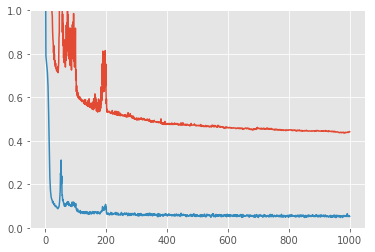

In [113]:
nepochs = 1001
trained_networks = []
for targets in [[training_targets_goals, test_targets_goals],
                [training_targets_assists, test_targets_assists],
                [training_targets_primary_assists, test_targets_primary_assists],
                [training_targets_points, test_targets_points]]:
    t1 = time.time()
    loss_train, loss_valid, network = train(training_data, targets[0], nepochs)
    print("Temps d'entrainement : {}".format(time.time()-t1))
    trained_networks.append(network)
    plt.plot(range(nepochs), loss_valid)
    plt.plot(range(nepochs), loss_train)
    plt.ylim([0,1])
    plt.show()

In [53]:
train_targets_list = [training_targets_goals, training_targets_assists,
                training_targets_primary_assists, training_targets_points]
test_targets_list = [test_targets_goals, test_targets_assists,
                test_targets_primary_assists, test_targets_points]
threshold_list = [5, 7, 5, 10]

In [115]:
predictions_mlp,error1_mlp, error2_mlp = [],[],[]
for network,labels in zip(trained_networks,test_targets_list):
    predictions_mlp.append(predict(network, test_data=test_data, test_labels=labels))
for labels, predictions, threshold in zip(test_targets_list, predictions_mlp, threshold_list): 
    error1_mlp.append(mean_squared_error(labels, predictions))
    not_small = np.where(labels > threshold)[0]
    error2_mlp.append(mean_squared_error(labels[not_small], predictions[not_small]))

In [20]:
svm = LinearSVR(dual=False,loss="squared_epsilon_insensitive")

predictions_svm, error1_svm, error2_svm = [],[],[]
for train_targets in train_targets_list:
    svm.fit(training_data, train_targets.ravel())
    predictions_svm.append(svm.predict(test_data))
for labels, predictions, threshold in zip(test_targets_list, predictions_svm, threshold_list):
    error1_svm.append(mean_squared_error(labels,predictions))
    not_small = np.where(labels > threshold)[0]
    error2_svm.append(mean_squared_error(labels[not_small],predictions[not_small]))

In [21]:
random_forest = ExtraTreesRegressor(bootstrap= False, max_features= 35, 
                                    min_samples_split=0.03, n_estimators= 75)
# random_forest = RandomForestRegressor(bootstrap=True, max_features=30,
#                                      min_samples_split=0.02, n_estimators=75)

predictions_rf, error1_rf, error2_rf = [],[],[]
for train_targets in train_targets_list:
    random_forest.fit(training_data, train_targets.ravel())
    predictions_rf.append(random_forest.predict(test_data))
for labels, predictions, threshold in zip(test_targets_list, predictions_rf, threshold_list):
    error1_rf.append(mean_squared_error(labels,predictions))
    not_small = np.where(labels > threshold)[0]
    error2_rf.append(mean_squared_error(labels[not_small],predictions[not_small]))

In [116]:
print(error1_mlp)
print(error2_mlp)
print(error1_rf)
print(error2_rf)
print(error1_svm)
print(error2_svm)

[9.594999, 12.896569, 4.130653, 24.939629]
[20.36171, 19.691566, 7.784704, 39.4249]
[9.561224387124419, 13.15213536222163, 3.4370103600415782, 29.430665160564143]
[19.50696059770699, 22.26872126999382, 6.932229758314357, 49.977171689045605]
[9.272237432684598, 12.790834401307968, 2.8200617229654226, 23.194680427596314]
[18.208231106681655, 21.517583361228755, 5.394957516930625, 37.37371071725948]


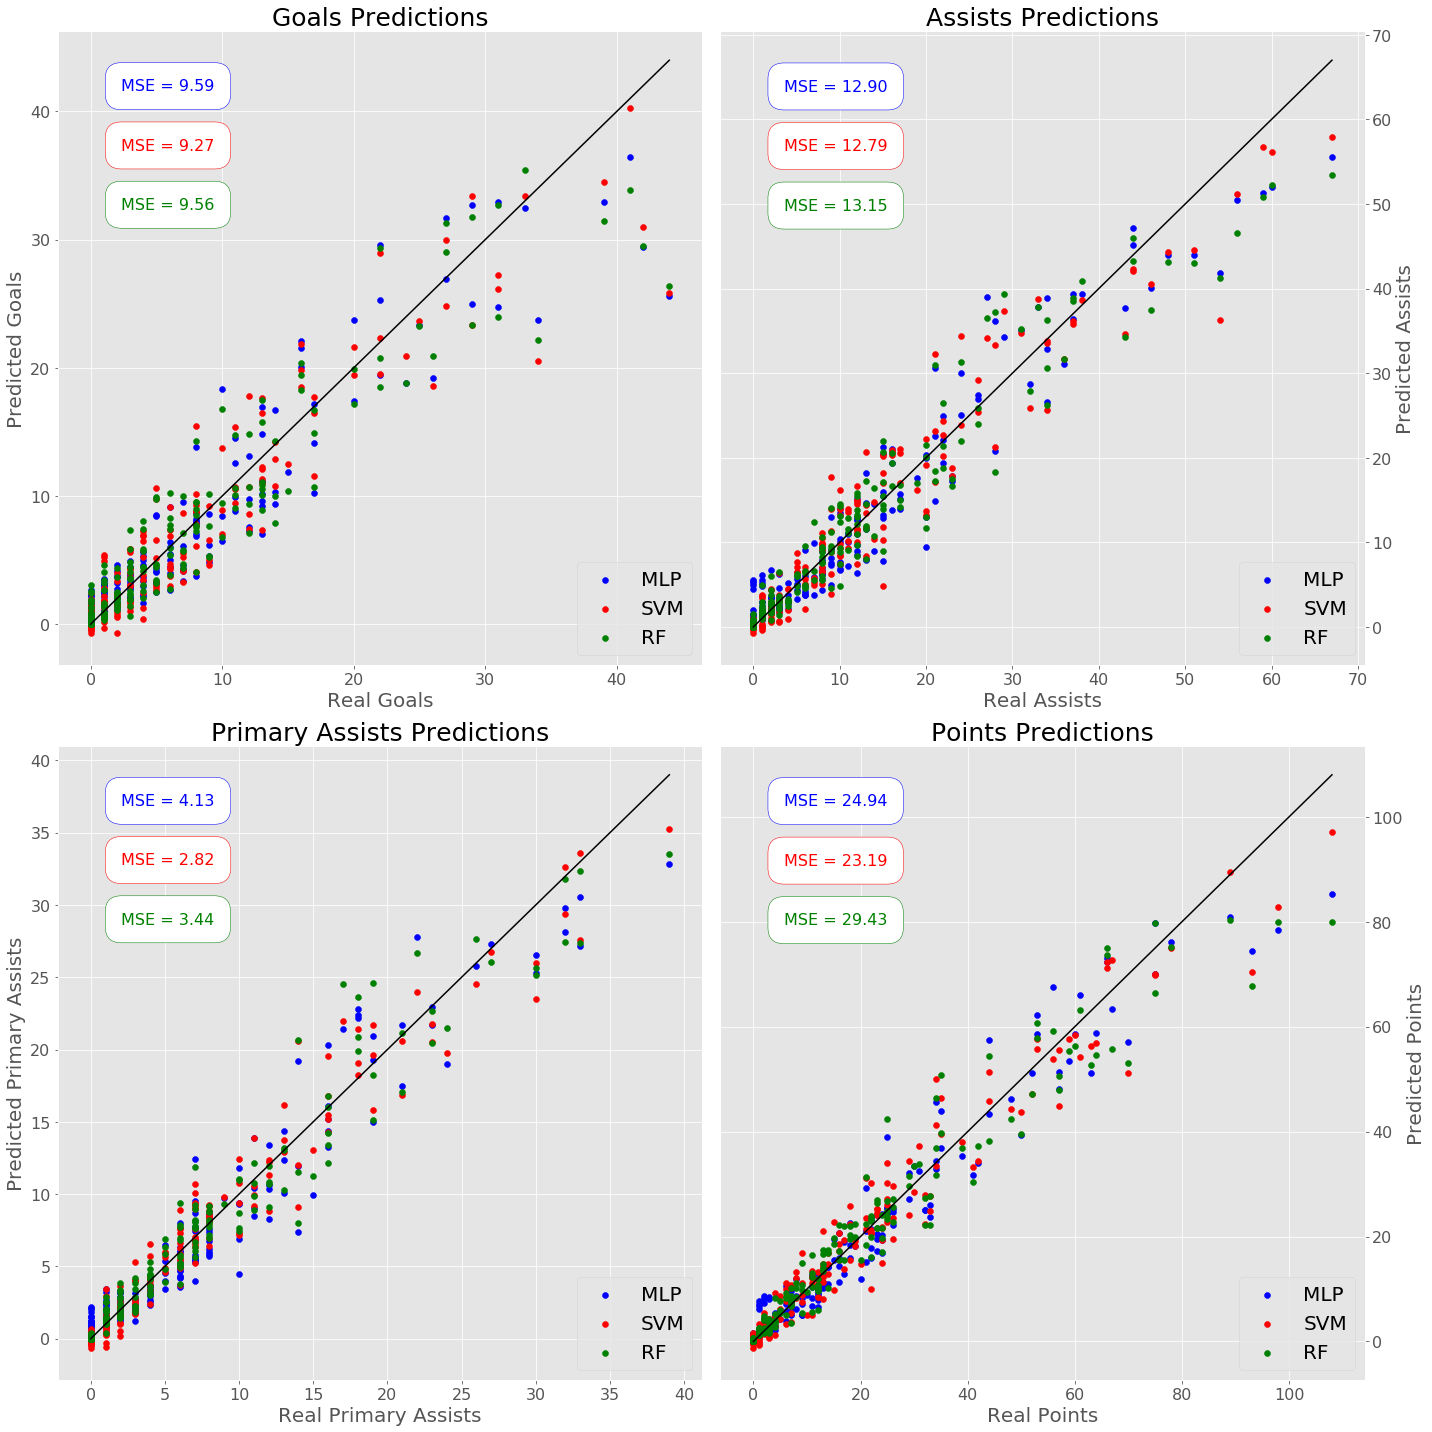

In [117]:
plt.style.use('ggplot') 
fig,ax = plt.subplots(nrows=2, ncols=2, figsize = (20,20))
ax1, ax2, ax3, ax4 = ax.flatten()

ax1.scatter(test_targets_goals, predictions_mlp[0], c = 'b', label = 'MLP')
ax1.scatter(test_targets_goals, predictions_svm[0], c = 'r', label = 'SVM')
ax1.scatter(test_targets_goals, predictions_rf[0], c = 'g', label = 'RF')
ax1.plot([0,np.max(test_targets_goals)],[0,np.max(test_targets_goals)], 'k')
ax1.text(0.05*ax1.get_xlim()[1], 0.9*ax1.get_ylim()[1], 'MSE = {:4.2f}'.format(error1_mlp[0]), color='b', 
        fontsize = 16, bbox=dict(facecolor='w', edgecolor='b', boxstyle='round,pad=1'))
ax1.text(0.05*ax1.get_xlim()[1], 0.8*ax1.get_ylim()[1], 'MSE = {:4.2f}'.format(error1_svm[0]), color='r', 
        fontsize = 16, bbox=dict(facecolor='w', edgecolor='r', boxstyle='round,pad=1'))
ax1.text(0.05*ax1.get_xlim()[1], 0.7*ax1.get_ylim()[1], 'MSE = {:4.2f}'.format(error1_rf[0]), color='g', 
        fontsize = 16, bbox=dict(facecolor='w', edgecolor='g', boxstyle='round,pad=1'))
ax1.set_xlabel('Real Goals', fontsize=20)
ax1.set_ylabel('Predicted Goals', fontsize=20)
ax1.set_title('Goals Predictions', fontsize=25)
ax1.legend(loc=4,fontsize=20)
ax1.tick_params(labelsize=16)

ax2.scatter(test_targets_assists, predictions_mlp[1], c = 'b', label = 'MLP')
ax2.scatter(test_targets_assists, predictions_svm[1], c = 'r', label = 'SVM')
ax2.scatter(test_targets_assists, predictions_rf[1], c = 'g', label = 'RF')
ax2.plot([0,np.max(test_targets_assists)],[0,np.max(test_targets_assists)], 'k')
ax2.text(0.05*ax2.get_xlim()[1], 0.9*ax2.get_ylim()[1], 'MSE = {:4.2f}'.format(error1_mlp[1]), color='b', 
        fontsize = 16, bbox=dict(facecolor='w', edgecolor='b', boxstyle='round,pad=1'))
ax2.text(0.05*ax2.get_xlim()[1], 0.8*ax2.get_ylim()[1], 'MSE = {:4.2f}'.format(error1_svm[1]), color='r', 
        fontsize = 16, bbox=dict(facecolor='w', edgecolor='r', boxstyle='round,pad=1'))
ax2.text(0.05*ax2.get_xlim()[1], 0.7*ax2.get_ylim()[1], 'MSE = {:4.2f}'.format(error1_rf[1]), color='g', 
        fontsize = 16, bbox=dict(facecolor='w', edgecolor='g', boxstyle='round,pad=1'))
ax2.set_xlabel('Real Assists', fontsize=20)
ax2.set_ylabel('Predicted Assists', fontsize=20)
ax2.set_title('Assists Predictions', fontsize=25)
ax2.legend(loc=4,fontsize=20)
ax2.tick_params(labelsize=16)
ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position("right")

ax3.scatter(test_targets_primary_assists, predictions_mlp[2], c = 'b', label = 'MLP')
ax3.scatter(test_targets_primary_assists, predictions_svm[2], c = 'r', label = 'SVM')
ax3.scatter(test_targets_primary_assists, predictions_rf[2], c = 'g', label = 'RF')
ax3.plot([0,np.max(test_targets_primary_assists)],[0,np.max(test_targets_primary_assists)], 'k')
ax3.text(0.05*ax3.get_xlim()[1], 0.9*ax3.get_ylim()[1], 'MSE = {:4.2f}'.format(error1_mlp[2]), color='b', 
        fontsize = 16, bbox=dict(facecolor='w', edgecolor='b', boxstyle='round,pad=1'))
ax3.text(0.05*ax3.get_xlim()[1], 0.8*ax3.get_ylim()[1], 'MSE = {:4.2f}'.format(error1_svm[2]), color='r', 
        fontsize = 16, bbox=dict(facecolor='w', edgecolor='r', boxstyle='round,pad=1'))
ax3.text(0.05*ax3.get_xlim()[1], 0.7*ax3.get_ylim()[1], 'MSE = {:4.2f}'.format(error1_rf[2]), color='g', 
        fontsize = 16, bbox=dict(facecolor='w', edgecolor='g', boxstyle='round,pad=1'))
ax3.set_xlabel('Real Primary Assists', fontsize=20)
ax3.set_ylabel('Predicted Primary Assists', fontsize=20)
ax3.set_title('Primary Assists Predictions', fontsize=25)
ax3.legend(loc=4,fontsize=20)
ax3.tick_params(labelsize=16)

ax4.scatter(test_targets_points, predictions_mlp[3], c = 'b', label = 'MLP')
ax4.scatter(test_targets_points, predictions_svm[3], c = 'r', label = 'SVM')
ax4.scatter(test_targets_points, predictions_rf[3], c = 'g', label = 'RF')
ax4.plot([0,np.max(test_targets_points)],[0,np.max(test_targets_points)], 'k')
ax4.text(0.05*ax4.get_xlim()[1], 0.9*ax4.get_ylim()[1], 'MSE = {:4.2f}'.format(error1_mlp[3]), color='b', 
        fontsize = 16, bbox=dict(facecolor='w', edgecolor='b', boxstyle='round,pad=1'))
ax4.text(0.05*ax4.get_xlim()[1], 0.8*ax4.get_ylim()[1], 'MSE = {:4.2f}'.format(error1_svm[3]), color='r', 
        fontsize = 16, bbox=dict(facecolor='w', edgecolor='r', boxstyle='round,pad=1'))
ax4.text(0.05*ax4.get_xlim()[1], 0.7*ax4.get_ylim()[1], 'MSE = {:4.2f}'.format(error1_rf[3]), color='g', 
        fontsize = 16, bbox=dict(facecolor='w', edgecolor='g', boxstyle='round,pad=1'))
ax4.set_xlabel('Real Points', fontsize=20)
ax4.set_ylabel('Predicted Points', fontsize=20)
ax4.set_title('Points Predictions', fontsize=25)
ax4.legend(loc=4,fontsize=20)
ax4.tick_params(labelsize=16)
ax4.yaxis.set_label_position("right")
ax4.yaxis.set_ticks_position("right")

fig.tight_layout()
plt.savefig('predictions.png')

In [42]:
# fig, ax = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(20,17))
# ax1, ax2, ax3, ax4 = ax.flatten()

# ax1.hist(deviations[0], bins=30, color='b')
# ax1.set_title('Goals Predictions', fontsize=20)
# ax1.set_xlabel('Relative Deviation', fontsize=15)
# ax1.set_ylabel('Counts', fontsize=15)
# ax1.text(0.65*ax1.get_xlim()[1], 0.8*ax1.get_ylim()[1], '$\sigma$ = {:5.3f}'.format(std[0]), color='black', 
#         fontsize = 20, bbox=dict(facecolor='w', edgecolor='black', 
#                   boxstyle='round,pad=1'))

# ax2.hist(deviations[1], bins=30, color='b')
# ax2.yaxis.tick_right()
# ax2.set_title('Assists Predictions', fontsize=20)
# ax2.set_xlabel('Relative Deviation', fontsize=15)
# ax2.text(0.65*ax2.get_xlim()[1], 0.8*ax2.get_ylim()[1], '$\sigma$ = {:5.3f}'.format(std[1]), color='black', 
#         fontsize = 20, bbox=dict(facecolor='w', edgecolor='black', 
#                   boxstyle='round,pad=1'))

# ax3.hist(deviations[2], bins=30, color='b')
# ax3.set_title('Primary Assists Predictions', fontsize=20)
# ax3.set_xlabel('Relative Deviation', fontsize=15)
# ax3.set_ylabel('Counts', fontsize=15)
# ax3.text(0.65*ax3.get_xlim()[1], 0.8*ax3.get_ylim()[1], '$\sigma$ = {:5.3f}'.format(std[2]), color='black', 
#         fontsize = 20, bbox=dict(facecolor='w', edgecolor='black', 
#                   boxstyle='round,pad=1'))

# ax4.hist(deviations[3], bins=30, color='b')
# ax4.yaxis.tick_right()
# ax4.set_title('Points Predictions', fontsize=20)
# ax4.set_xlabel('Relative Deviation', fontsize=15)
# ax4.text(0.65*ax4.get_xlim()[1], 0.8*ax4.get_ylim()[1], '$\sigma$ = {:5.3f}'.format(std[3]), color='black', 
#         fontsize = 20, bbox=dict(facecolor='w', edgecolor='black', 
#                   boxstyle='round,pad=1'))

# plt.show()